In [ ]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480

In [ ]:
from collections import OrderedDict
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
# disable_progress_bar controls the visibility of progress bars
from torch.utils.data import DataLoader
import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

In [ ]:
NUM_CLIENTS = 10
BATCH_SIZE = 32

from flwr_datasets.partitioner import DirichletPartitioner
partitioner = DirichletPartitioner(num_partitions=NUM_CLIENTS,alpha=0.05,partition_by="label",seed=42)

In [ ]:
def load_datasets(partition_id: int):
    fds=FederatedDataset(dataset="cifar10", partitioners={"train": partitioner})
    partition=fds.load_partition(partition_id)

    print(f"Partition {partition_id} size: {len(partition)}")
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    print(f"Partition {partition_id} train size: {len(partition_train_test['train'])}")
    print(f"Partition {partition_id} test size: {len(partition_train_test['test'])}")

    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )
    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    train_batch_size = min(BATCH_SIZE, max(2, len(partition_train_test["train"])))

    trainloader = DataLoader(
        partition_train_test["train"],
        batch_size=train_batch_size,
        shuffle=True,
        drop_last=(len(partition_train_test["train"]) % train_batch_size == 1)
    )

    valloader = DataLoader(
        partition_train_test["test"],
        batch_size=BATCH_SIZE,
        drop_last=(len(partition_train_test["test"]) == 1)
    )

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)

    return trainloader, valloader, testloader

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict()
    for k, v in params_dict:
        if v.size == 0:
            print(f"Warning: Parameter {k} is empty!")
            continue
        state_dict[k] = torch.tensor(v)

    net.load_state_dict(state_dict, strict=True)

In [ ]:
def train(net,trainloader,epochs:int,global_params=None,mu:float=0.0,verbose=False): # adding proximal term coefficient (mu)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(),lr=0.01)
    # optimizer = torch.optim.Adam(net.parameters())
    net.train()

    for epoch in range(epochs):
        correct,total,epoch_loss=0,0,0.0
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs=net(images)
            ce_loss=criterion(outputs,labels)

            # If global model parameters are given and mu is non-zero, apply FedProx algorithm
            if global_params is not None and mu>0:
                prox_term=0.0
                for param,global_param in zip(net.parameters(),global_params):
                    prox_term+=((param-global_param.to(DEVICE))**2).sum()
                ce_loss+=(mu/2)*prox_term # Adding the proximal penalty to the cross-entropy loss

            ce_loss.backward()
            optimizer.step()
            epoch_loss+=ce_loss.item()
            total+=labels.size(0)
            correct+=(outputs.argmax(dim=1)==labels).sum().item()

        if verbose:
            print(f"Epoch {epoch+1}: Train Loss = {epoch_loss:.4f}, Accuracy = {correct / total:.4f}")

In [ ]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net=net
        self.trainloader=trainloader
        self.valloader=valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net,parameters)
        mu=float(config.get("mu",0.0))
        global_params=[torch.tensor(p,dtype=torch.float32).to(DEVICE) for p in parameters]
        train(self.net,self.trainloader,epochs=1,global_params=global_params,mu=mu)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""
    net = Net().to(DEVICE)
    print(f"Context data: {context.__dict__}")

    partition_id = int(context.node_id) % NUM_CLIENTS if hasattr(context, 'node_id') else 0
    if hasattr(context, 'node_config') and 'partition_id' in context.node_config:
        partition_id = context.node_config['partition_id']

    print(f"Using partition_id: {partition_id}")
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)
    return FlowerClient(net, trainloader, valloader).to_client()

client = ClientApp(client_fn=client_fn)

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
from flwr.server.strategy import FedProx

fedprox_accuracies = []
lossp_values = []

class CustomFedProx(FedProx):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result = super().aggregate_evaluate(server_round, results, failures)

        if aggregated_result is not None:
            loss, metrics = aggregated_result
            accuracy = metrics.get("accuracy", 0.0)
            fedprox_accuracies.append(accuracy)
            lossp_values.append(loss)
            print(f"Round {server_round}: Loss: {loss:.4f} Test Accuracy: {accuracy:.4f}")

        return aggregated_result

strategy = CustomFedProx(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
    proximal_mu=0.01
)

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=50)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

In [ ]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=8863) 2025-05-01 04:36:02.413559: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=8863) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=8863) E0000 00:00:1746074162.433046    8863 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=8863) E0000 00:00:1746074162.439059    8863 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=8863) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is mig

(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9


Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 111628.72 examples/s]
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8863) Partition 9 size: 4404
(ClientAppActor pid=8863) Partition 9 train size: 3523
(ClientAppActor pid=8863) Partition 9 test size: 881
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_recor

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16443760972666180536, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 11684413187167044307, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 7
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 1: Loss: 0.0643 Test Accuracy: 0.2117
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16204977870532168175, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 5
(ClientAppActor pid=8863) Partition 5 size: 4272
(ClientAppActor pid=8863) Partition 5 train size: 3417
(ClientAppActor pid=8863) Partition 5 test size: 855
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16443760972666180536, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 2: Loss: 0.0600 Test Accuracy: 0.3846
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppAct

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAp

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 3: Loss: 0.0520 Test Accuracy: 0.4088
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppAct

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAp

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 4: Loss: 0.0571 Test Accuracy: 0.2634
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16204977870532168175, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 3
(ClientAppActor pid=8863) Partition 3 size: 4835
(ClientAppActor pid=8863) Partition 3 train size: 3868
(ClientAppActor pid=8863) Partition 3 test size: 967
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16204977870532168175, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 5
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 5: Loss: 0.0592 Test Accuracy: 0.2345
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppAct

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16204977870532168175, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 5
(ClientAppActor pid=8863) Partition 5 size: 4272
(ClientAppActor pid=8863) Partition 5 train size: 3417
(ClientAppActor pid=8863) Partition 5 test size: 855
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16443760972666180536, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 6: Loss: 0.0536 Test Accuracy: 0.3320
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppAct

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAppActor pid=8863) Partition 9 size: 4404
(ClientAppActor pid=8863) Partition 9 train size: 3523
(ClientAppActor pid=8863) Partition 9 test size: 881
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 3
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 7: Loss: 0.0491 Test Accuracy: 0.4146
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppAct

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 3
(ClientA

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 8: Loss: 0.0489 Test Accuracy: 0.4287
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAppActor pid=8863) Partition 9 size: 4404
(ClientAppActor pid=8863) Partition 9 train size: 3523
(ClientAppActor pid=8863) Partition 9 test size: 881
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16204977870532168175, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientApp

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAppActor pid=8863) Partition 9 size: 4404
(ClientAppActor pid=8863) Partition 9 train size: 3523
(ClientAppActor pid=8863) Partition 9 test size: 881
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16204977870532168175, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 5
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 9: Loss: 0.0454 Test Accuracy: 0.4633
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAppActor pid=8863) Partition 9 size: 4404
(ClientAppActor pid=8863) Partition 9 train size: 3523
(ClientAppActor pid=8863) Partition 9 test size: 881
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientApp

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 3
(ClientAppActor pid=8863) Partition 3 size: 4835
(ClientAppActor pid=8863) Partition 3 train size: 3868
(ClientAppActor pid=8863) Partition 3 test size: 967
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16204977870532168175, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 5
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 10: Loss: 0.0506 Test Accuracy: 0.3486
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAppActor pid=8863) Partition 9 size: 4404
(ClientAppActor pid=8863) Partition 9 train size: 3523
(ClientAppActor pid=8863) Partition 9 test size: 881
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAp

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAp

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 11: Loss: 0.0482 Test Accuracy: 0.4230
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAp

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 12: Loss: 0.0480 Test Accuracy: 0.4021
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAppActor pid=8863) Partition 9 size: 4404
(ClientAppActor pid=8863) Partition 9 train size: 3523
(ClientAppActor pid=8863) Partition 9 test size: 881
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 3
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 13: Loss: 0.0478 Test Accuracy: 0.3814
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppA

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAppActor pid=8863) Partition 9 size: 4404
(ClientAppActor pid=8863) Partition 9 train size: 3523
(ClientAppActor pid=8863) Partition 9 test size: 881
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 3
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 14: Loss: 0.0469 Test Accuracy: 0.4175
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16204977870532168175, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 5
(ClientAppActor pid=8863) Partition 5 size: 4272
(ClientAppActor pid=8863) Partition 5 train size: 3417
(ClientAppActor pid=8863) Partition 5 test size: 855
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16443760972666180536, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 15: Loss: 0.0431 Test Accuracy: 0.4304
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAppActor pid=8863) Partition 9 size: 4404
(ClientAppActor pid=8863) Partition 9 train size: 3523
(ClientAppActor pid=8863) Partition 9 test size: 881
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16443760972666180536, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 16: Loss: 0.0434 Test Accuracy: 0.4570
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAppActor pid=8863) Partition 9 size: 4404
(ClientAppActor pid=8863) Partition 9 train size: 3523
(ClientAppActor pid=8863) Partition 9 test size: 881
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAp

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 3
(ClientAppActor pid=8863) Partition 3 size: 4835
(ClientAppActor pid=8863) Partition 3 train size: 3868
(ClientAppActor pid=8863) Partition 3 test size: 967
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16204977870532168175, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 5
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8863) Partition 1 size: 940
(ClientAppActor pid=8863) Partition 1 train size: 752
(ClientAppActor pid=8863) Partition 1 test size: 188
Round 17: Loss: 0.0461 Test Accuracy: 0.4269
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAp

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 18: Loss: 0.0493 Test Accuracy: 0.3440
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAp

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 19: Loss: 0.0446 Test Accuracy: 0.4325
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAppActor pid=8863) Partition 9 size: 4404
(ClientAppActor pid=8863) Partition 9 train size: 3523
(ClientAppActor pid=8863) Partition 9 test size: 881
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAp

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAppActor pid=8863) Partition 9 size: 4404
(ClientAppActor pid=8863) Partition 9 train size: 3523
(ClientAppActor pid=8863) Partition 9 test size: 881
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 3
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 20: Loss: 0.0456 Test Accuracy: 0.4378
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 3
(ClientAppActor pid=8863) Partition 3 size: 4835
(ClientAppActor pid=8863) Partition 3 train size: 3868
(ClientAppActor pid=8863) Partition 3 test size: 967
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16204977870532168175, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 5
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 21: Loss: 0.0425 Test Accuracy: 0.4753
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 3
(ClientAppActor pid=8863) Partition 3 size: 4835
(ClientAppActor pid=8863) Partition 3 train size: 3868
(ClientAppActor pid=8863) Partition 3 test size: 967
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16204977870532168175, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientA

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16204977870532168175, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 5
(ClientA

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 22: Loss: 0.0483 Test Accuracy: 0.3131
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 3
(ClientAppActor pid=8863) Partition 3 size: 4835
(ClientAppActor pid=8863) Partition 3 train size: 3868
(ClientAppActor pid=8863) Partition 3 test size: 967
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16443760972666180536, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientA

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAppActor pid=8863) Partition 9 size: 4404
(ClientAppActor pid=8863) Partition 9 train size: 3523
(ClientAppActor pid=8863) Partition 9 test size: 881
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16204977870532168175, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 5
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 23: Loss: 0.0376 Test Accuracy: 0.5572
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 3
(ClientAppActor pid=8863) Partition 3 size: 4835
(ClientAppActor pid=8863) Partition 3 train size: 3868
(ClientAppActor pid=8863) Partition 3 test size: 967
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16204977870532168175, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientA

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAp

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 24: Loss: 0.0411 Test Accuracy: 0.4847
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16204977870532168175, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppA

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16204977870532168175, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 5
(ClientAppActor pid=8863) Partition 5 size: 4272
(ClientAppActor pid=8863) Partition 5 train size: 3417
(ClientAppActor pid=8863) Partition 5 test size: 855
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16443760972666180536, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 25: Loss: 0.0392 Test Accuracy: 0.5154
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 3
(ClientAppActor pid=8863) Partition 3 size: 4835
(ClientAppActor pid=8863) Partition 3 train size: 3868
(ClientAppActor pid=8863) Partition 3 test size: 967
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16204977870532168175, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientA

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAp

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 26: Loss: 0.0358 Test Accuracy: 0.5919
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAppActor pid=8863) Partition 9 size: 4404
(ClientAppActor pid=8863) Partition 9 train size: 3523
(ClientAppActor pid=8863) Partition 9 test size: 881
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16204977870532168175, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAp

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16443760972666180536, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 11684413187167044307, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 7
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 27: Loss: 0.0387 Test Accuracy: 0.5241
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAppActor pid=8863) Partition 9 size: 4404
(ClientAppActor pid=8863) Partition 9 train size: 3523
(ClientAppActor pid=8863) Partition 9 test size: 881
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAp

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16204977870532168175, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 5
(ClientAppActor pid=8863) Partition 5 size: 4272
(ClientAppActor pid=8863) Partition 5 train size: 3417
(ClientAppActor pid=8863) Partition 5 test size: 855
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16443760972666180536, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 28: Loss: 0.0409 Test Accuracy: 0.4426
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppA

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAppActor pid=8863) Partition 9 size: 4404
(ClientAppActor pid=8863) Partition 9 train size: 3523
(ClientAppActor pid=8863) Partition 9 test size: 881
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16443760972666180536, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 29: Loss: 0.0390 Test Accuracy: 0.5260
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAppActor pid=8863) Partition 9 size: 4404
(ClientAppActor pid=8863) Partition 9 train size: 3523
(ClientAppActor pid=8863) Partition 9 test size: 881
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAp

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAp

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 30: Loss: 0.0420 Test Accuracy: 0.4566
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAppActor pid=8863) Partition 9 size: 4404
(ClientAppActor pid=8863) Partition 9 train size: 3523
(ClientAppActor pid=8863) Partition 9 test size: 881
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAp

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16204977870532168175, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 5
(ClientA

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 31: Loss: 0.0406 Test Accuracy: 0.4864
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) 
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Usin

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 32: Loss: 0.0380 Test Accuracy: 0.5339
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16204977870532168175, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppA

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 3
(ClientAppActor pid=8863) Partition 3 size: 4835
(ClientAppActor pid=8863) Partition 3 train size: 3868
(ClientAppActor pid=8863) Partition 3 test size: 967
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16443760972666180536, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 33: Loss: 0.0431 Test Accuracy: 0.4632
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppA

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAppActor pid=8863) Partition 9 size: 4404
(ClientAppActor pid=8863) Partition 9 train size: 3523
(ClientAppActor pid=8863) Partition 9 test size: 881
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 3
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 34: Loss: 0.0405 Test Accuracy: 0.4958
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 11684413187167044307, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 7
(ClientAppActor pid=8863) Partition 7 size: 6226
(ClientAppActor pid=8863) Partition 7 train size: 4980
(ClientAppActor pid=8863) Partition 7 test size: 1246
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 11381952253764389141, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 1
(Cli

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 35: Loss: 0.0380 Test Accuracy: 0.5403
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAppActor pid=8863) Partition 9 size: 4404
(ClientAppActor pid=8863) Partition 9 train size: 3523
(ClientAppActor pid=8863) Partition 9 test size: 881
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16204977870532168175, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAp

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAp

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 36: Loss: 0.0411 Test Accuracy: 0.5132
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAppActor pid=8863) Partition 9 size: 4404
(ClientAppActor pid=8863) Partition 9 train size: 3523
(ClientAppActor pid=8863) Partition 9 test size: 881
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAp

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAppActor pid=8863) Partition 9 size: 4404
(ClientAppActor pid=8863) Partition 9 train size: 3523
(ClientAppActor pid=8863) Partition 9 test size: 881
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 3
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 37: Loss: 0.0423 Test Accuracy: 0.4620
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16204977870532168175, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 5
(ClientAppActor pid=8863) Partition 5 size: 4272
(ClientAppActor pid=8863) Partition 5 train size: 3417
(ClientAppActor pid=8863) Partition 5 test size: 855
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 11684413187167044307, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 7
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 38: Loss: 0.0347 Test Accuracy: 0.6045
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16204977870532168175, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppA

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 3
(ClientA

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 39: Loss: 0.0434 Test Accuracy: 0.4409
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16204977870532168175, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppA

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAppActor pid=8863) Partition 9 size: 4404
(ClientAppActor pid=8863) Partition 9 train size: 3523
(ClientAppActor pid=8863) Partition 9 test size: 881
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 3
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 40: Loss: 0.0414 Test Accuracy: 0.4626
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAppActor pid=8863) Partition 9 size: 4404
(ClientAppActor pid=8863) Partition 9 train size: 3523
(ClientAppActor pid=8863) Partition 9 test size: 881
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAp

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 3
(ClientA

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 41: Loss: 0.0463 Test Accuracy: 0.3880
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 3
(ClientA

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 42: Loss: 0.0414 Test Accuracy: 0.5013
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 3
(ClientA

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 43: Loss: 0.0455 Test Accuracy: 0.3990
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppA

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 3
(ClientAppActor pid=8863) Partition 3 size: 4835
(ClientAppActor pid=8863) Partition 3 train size: 3868
(ClientAppActor pid=8863) Partition 3 test size: 967
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16204977870532168175, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 5
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 44: Loss: 0.0414 Test Accuracy: 0.4630
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 3
(ClientAppActor pid=8863) Partition 3 size: 4835
(ClientAppActor pid=8863) Partition 3 train size: 3868
(ClientAppActor pid=8863) Partition 3 test size: 967
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 16443760972666180536, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientA

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 7172553645969159396, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 6
(ClientAppActor pid=8863) Partition 6 size: 570
(ClientAppActor pid=8863) Partition 6 train size: 456
(ClientAppActor pid=8863) Partition 6 test size: 114
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 3
(ClientA

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 45: Loss: 0.0416 Test Accuracy: 0.4752
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 4112569008292000689, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAppActor pid=8863) Using partition_id: 9
(ClientAppActor pid=8863) Partition 9 size: 4404
(ClientAppActor pid=8863) Partition 9 train size: 3523
(ClientAppActor pid=8863) Partition 9 test size: 881
(ClientAppActor pid=8863) Context data: {'run_id': 17881657976994556598, 'node_id': 18386830354289544143, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=8863)   array_records={},
(ClientAppActor pid=8863)   metric_records={},
(ClientAppActor pid=8863)   config_records={}
(ClientAppActor pid=8863) ), 'run_config': {}}
(ClientAp

In [ ]:
print("\n===== SUMMARY OF TEST ACCURACIES =====")
for round_num, accuracy in enumerate(fedprox_accuracies, 1):
    print(f"Round {round_num}: {accuracy:.4f}")
print("=====================================\n")

In [ ]:
def plot_loss():
    plt.figure(figsize=(9,3))
    plt.plot(range(1, len(lossp_values) + 1), lossp_values, linestyle='-')
    plt.title('Loss vs Server Round')
    plt.xlabel('Server Round')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

plot_loss()

In [ ]:
def plot_accuracy_vs_rounds():
    if fedprox_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(fedprox_accuracies) + 1), fedprox_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()

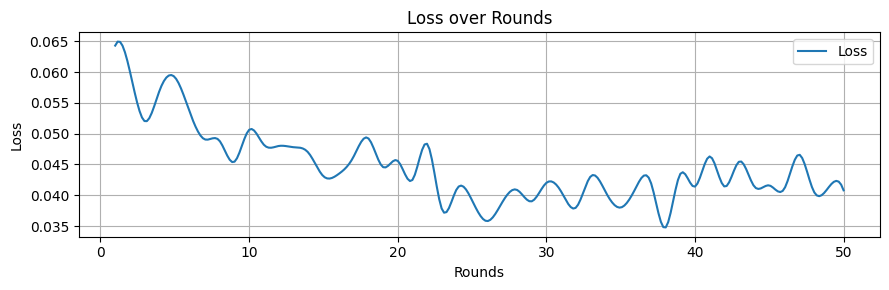

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Loss and accuracy values from 50 rounds
loss = [
    0.0643, 0.0600, 0.0520, 0.0571, 0.0592, 0.0536, 0.0491, 0.0489, 0.0454, 0.0506,
    0.0482, 0.0480, 0.0478, 0.0469, 0.0431, 0.0434, 0.0461, 0.0493, 0.0446, 0.0456,
    0.0425, 0.0483, 0.0376, 0.0411, 0.0392, 0.0358, 0.0387, 0.0409, 0.0390, 0.0420,
    0.0406, 0.0380, 0.0431, 0.0405, 0.0380, 0.0411, 0.0423, 0.0347, 0.0434, 0.0414,
    0.0463, 0.0414, 0.0455, 0.0414, 0.0416, 0.0410, 0.0466, 0.0406, 0.0413, 0.0408
]


rounds = np.arange(1, 51)

# Smoothing function
def smooth(x, y):
    x_new = np.linspace(x.min(), x.max(), 300)
    y_smooth = make_interp_spline(x, y, k=3)(x_new)
    return x_new, y_smooth

# Smooth the curves
x_loss, y_loss = smooth(rounds, np.array(loss))

# Plotting
plt.figure(figsize=(9,3))
plt.plot(x_loss, y_loss, label="Loss")
plt.xlabel("Rounds")
plt.ylabel("Loss")
plt.title("Loss over Rounds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


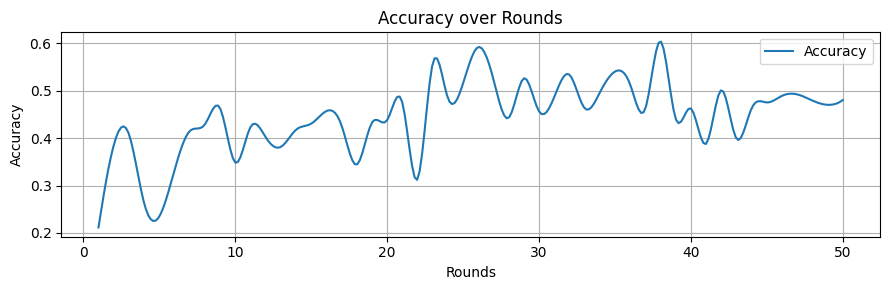

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

accuracy = [
    0.2117, 0.3846, 0.4088, 0.2634, 0.2345, 0.3320, 0.4146, 0.4287, 0.4633, 0.3486,
    0.4230, 0.4021, 0.3814, 0.4175, 0.4304, 0.4570, 0.4269, 0.3440, 0.4325, 0.4378,
    0.4753, 0.3131, 0.5572, 0.4847, 0.5154, 0.5919, 0.5241, 0.4426, 0.5260, 0.4566,
    0.4864, 0.5339, 0.4632, 0.4958, 0.5403, 0.5132, 0.4620, 0.6045, 0.4409, 0.4626,
    0.3880, 0.5013, 0.3990, 0.4630, 0.4752, 0.4892, 0.4922, 0.4792, 0.4702, 0.4802
]

rounds = np.arange(1, 51)

# Smoothing function
def smooth(x, y):
    x_new = np.linspace(x.min(), x.max(), 300)
    y_smooth = make_interp_spline(x, y, k=3)(x_new)
    return x_new, y_smooth

# Smooth the curves
x_acc, y_acc = smooth(rounds, np.array(accuracy))

# Plotting
plt.figure(figsize=(9,3))
plt.plot(x_acc, y_acc, label="Accuracy")
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.title("Accuracy over Rounds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

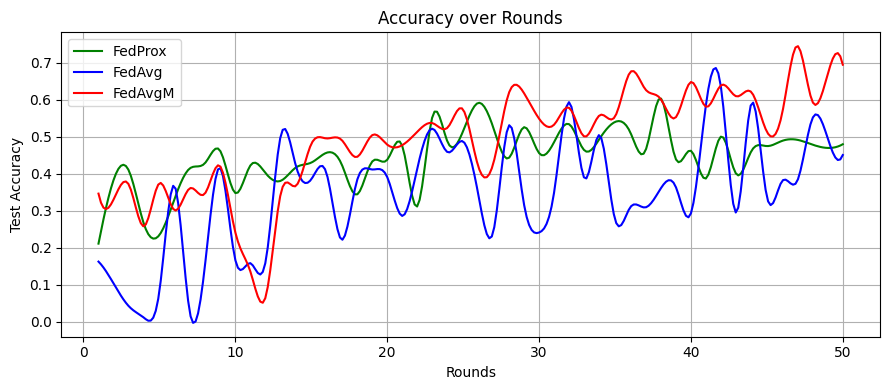

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Rounds
rounds = np.arange(1, 51)

# Accuracy values
fedprox = [
    0.2117, 0.3846, 0.4088, 0.2634, 0.2345, 0.3320, 0.4146, 0.4287, 0.4633, 0.3486,
    0.4230, 0.4021, 0.3814, 0.4175, 0.4304, 0.4570, 0.4269, 0.3440, 0.4325, 0.4378,
    0.4753, 0.3131, 0.5572, 0.4847, 0.5154, 0.5919, 0.5241, 0.4426, 0.5260, 0.4566,
    0.4864, 0.5339, 0.4632, 0.4958, 0.5403, 0.5132, 0.4620, 0.6045, 0.4409, 0.4626,
    0.3880, 0.5013, 0.3990, 0.4630, 0.4752, 0.4892, 0.4922, 0.4792, 0.4702, 0.4802
]

fedavg = [
    0.1631, 0.1035, 0.0424, 0.0113, 0.0802, 0.3682, 0.0288, 0.1493, 0.4168, 0.1690,
    0.1589, 0.1627, 0.5037, 0.4211, 0.3850, 0.4034, 0.2223, 0.3793, 0.4120, 0.3923,
    0.2865, 0.4171, 0.5221, 0.4584, 0.4879, 0.3453, 0.2449, 0.5295, 0.3210, 0.2416,
    0.3515, 0.5935, 0.3877, 0.5045, 0.2780, 0.3094, 0.3095, 0.3597, 0.3656, 0.2931,
    0.5891, 0.6286, 0.2956, 0.5921, 0.3388, 0.3804, 0.3806, 0.5498, 0.4975, 0.4511
]

fedavgm = [
    0.3468, 0.3316, 0.3708, 0.2585, 0.3746, 0.3020, 0.3609, 0.3466, 0.4214, 0.2436,
    0.1362, 0.0670, 0.3472, 0.3677, 0.4801, 0.4959, 0.4921, 0.4456, 0.5042, 0.4794,
    0.4778, 0.5144, 0.5371, 0.5259, 0.5741, 0.4207, 0.4295, 0.6164, 0.6191, 0.5496,
    0.5333, 0.5780, 0.5007, 0.5587, 0.5545, 0.6746, 0.6287, 0.6031, 0.5525, 0.6482,
    0.5814, 0.6399, 0.6095, 0.6202, 0.5143, 0.5621, 0.7460, 0.5955, 0.6683, 0.6951
]

# Smoothing function
def smooth(x, y):
    x_new = np.linspace(x.min(), x.max(), 300)
    y_smooth = make_interp_spline(x, y, k=3)(x_new)
    return x_new, y_smooth

# Smooth all three curves
x_fedprox, y_fedprox = smooth(rounds, np.array(fedprox))
x_fedavg, y_fedavg = smooth(rounds, np.array(fedavg))
x_fedavgm, y_fedavgm = smooth(rounds, np.array(fedavgm))

# Plotting
plt.figure(figsize=(9,4))
plt.plot(x_fedprox, y_fedprox, label="FedProx", color='green')
plt.plot(x_fedavg, y_fedavg, label="FedAvg", color='blue')
plt.plot(x_fedavgm, y_fedavgm, label="FedAvgM", color='red')

plt.xlabel("Rounds")
plt.ylabel("Test Accuracy")
plt.title("Accuracy over Rounds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
